## Experiments with (deep) CNNs
First we tried different CNNs out to check how these can solve the problem.

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers.convolutional import Conv1D, MaxPooling1D
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from timeit import default_timer as timer
from skimage import io, color
import os
import zipfile

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The following functions was firstly introduced in Milestone1. The functionalities are the same, but each had a little change to be compatible with Keras networks. So 'rearrange' returns 4D numpy array, that we can train on. 'lab_show' and 'output_scaler' now has a 3D numpy array as input. 

In [4]:
# this function helps to refer a picture's values
# it doesn't copy any data
def rearrange(data, im_w = 128, im_h = 128):
    arranged_data = []
    for i in range(data.shape[0]//im_h): # iterating in all pictures
        arranged_data.append([data[i*im_h:(i+1)*im_h,0:im_w], # L channel
                              data[i*im_h:(i+1)*im_h,im_w:2*im_w], # a channel
                              data[i*im_h:(i+1)*im_h,2*im_w:]]) # b channel
    arranged_data = np.array([np.swapaxes(np.swapaxes(np.array((arranged_data[ind][0],arranged_data[ind][1],arranged_data[ind][2])),0,1),1,2) for ind in range(len(arranged_data))])
    return arranged_data #the form is: arrenged_data[picture][channel] (type: numpy.ndarray)



#visualizzation - shows all channels of  an image in LAB color space
def lab_show(img):
    plt.figure
    plt.rcParams["figure.figsize"] = [15,10] # bigger plot size
    #creating color map from L = 0 to L = 100
    cmL = LinearSegmentedColormap.from_list('L channel', [(0, 0, 0), (1, 1, 1)], N=101)
    plt.subplot(131) # 1 row, 3 columns, 1st figure
    plt.title('L channel')
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(img[:,:,0], cmap=cmL, vmin = 0, vmax = 100)
    # creating color map from a = -128 to a = +127
    # note: color map values are just for visualization
    cmA = LinearSegmentedColormap.from_list('a channel', [(0.153, 0.922, 0.722), (1, 0, 0.392)], N=2550)
    plt.subplot(132) # 1 row, 3 columns, 2nd figure
    plt.title('A channel')
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(img[:,:,1], cmap=cmA, vmin = -128, vmax = 127)
    
    # creating color map from b = -128 to a = +127
    # note: color map values are just for visualization
    cmB = LinearSegmentedColormap.from_list('b channel', [(0, 0, 1), (1, 0.902, 0)], N=255)
    plt.subplot(133) # 1 row, 3 columns, 3rd figure
    plt.title('B channel')
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(img[:,:,2], cmap=cmB, vmin = -128, vmax = 127)
    plt.show()
    
def outputscaler(img): #function to upscale our image for the excel output, the plt.imshow() finction does not need upscaling
    #funtcion of min-max scaling: y = (x-min(x))/(max(x)-min(x)), we need to reverse this: x = y*(max(x)-min(x)) + min(x)
    ret = np.zeros(img.shape)
    ret[:,:,0] = np.round(img[:,:,0]*100)     #L channel goes from 0 - +100
    ret[:,:,1] = np.round((img[:,:,1]*255))-128 #a channel goes from -128 to +127
    ret[:,:,2] = np.round((img[:,:,2]*255))-128 #b channel goes from -128 to +127
    return ret

We changed the way how to store learning datas on HDD. Instead of saving float values we save int values, becaues it requires much less sapce. Therefore we needed a scaler after reading datas. This is done by 'scale_learning_data' function. <br> Also we zipped the datas, so know the whole 10000 images are less the 0.3 GB. (It was about 7 GB before.)

In [5]:
# normalizing learning datas
def scale_learning_data(train_data, valid_data, test_data):
    
    # input normalizer #L channel scale /100
    train_data[:,0:128] = train_data[:,0:128]/100 
    valid_data[:,0:128] = valid_data[:,0:128]/100 
    test_data[:,0:128] = test_data[:,0:128]/100 
    
    # output normalizer #A and B channel scale
    train_data[:,128:] = (train_data[:,128:]+128)/255
    valid_data[:,128:] = (valid_data[:,128:]+128)/255
    test_data[:,128:] = (test_data[:,128:]+128)/255
                  
    return train_data, valid_data, test_data

In [6]:
#read data
start=timer()
path2 = "data/" #learning data directory
with zipfile.ZipFile('data/3.zip', 'r',zipfile.ZIP_DEFLATED) as myzip: #ZIP_DEFLATED 11.2s vs BZIP2 60s
    myzip.extractall('data/')
    
# read learning data back with pandas
train = pd.read_csv(path2 + 'train.csv', header=None, dtype = np.float32).values # convert to numpy array
valid = pd.read_csv(path2 + 'valid.csv', header=None, dtype = np.float32).values # convert to numpy array
test = pd.read_csv(path2 + 'test.csv', header=None, dtype = np.float32).values # convert to numpy array

os.remove("data/test.csv")
os.remove("data/train.csv")
os.remove("data/valid.csv")
print(timer()-start)

88.82401779306483


In [7]:
train, valid, test = scale_learning_data(train, valid, test) # normalizing
train = rearrange(train)
valid = rearrange(valid)
# trainX = np.array([np.atleast_3d(train_ar[ind][0]) for ind in range(len(train_ar))])
# trainY = np.array([np.swapaxes(np.swapaxes(np.array((train_ar[ind][1],train_ar[ind][2])),0,1),1,2) for ind in range(len(train_ar))])
# validX = np.array([np.atleast_3d(valid_ar[ind][0]) for ind in range(len(valid_ar))])
# validY = np.array([np.swapaxes(np.swapaxes(np.array((valid_ar[ind][1],valid_ar[ind][2])),0,1),1,2) for ind in range(len(valid_ar))])

In [6]:
train[:,:,:,0:1].shape

(7000, 128, 128, 1)

#### Creating NN
We tried different convolution neural networks based on __[this source code](https://github.com/emilwallner/Coloring-greyscale-images-in-Keras/blob/master/local/Full-version/full_version.ipynb)__. <br>
It seems less layers makes better performance, because with too deep network we faces the vanishing gradient problem. Unforunatelly even the best models can't color portraits properly. All it does is just adding some light brown filter on the whole picture.

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(128, 128, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [59]:
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

model.fit(train[:,:,:,0:1], train[:,:,:,1:3], epochs = 10, batch_size = 128, verbose=2,
          validation_data=(valid[:,:,:,0:1], valid[:,:,:,1:3]),
          callbacks=[checkpointer])

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
 - 15s - loss: 0.0326 - mean_absolute_error: 0.1234 - val_loss: 0.0038 - val_mean_absolute_error: 0.0460

Epoch 00001: val_loss improved from inf to 0.00381, saving model to weights.hdf5
Epoch 2/10
 - 12s - loss: 0.0030 - mean_absolute_error: 0.0401 - val_loss: 0.0025 - val_mean_absolute_error: 0.0359

Epoch 00002: val_loss improved from 0.00381 to 0.00249, saving model to weights.hdf5
Epoch 3/10
 - 12s - loss: 0.0023 - mean_absolute_error: 0.0342 - val_loss: 0.0024 - val_mean_absolute_error: 0.0354

Epoch 00003: val_loss improved from 0.00249 to 0.00237, saving model to weights.hdf5
Epoch 4/10
 - 12s - loss: 0.0021 - mean_absolute_error: 0.0323 - val_loss: 0.0021 - val_mean_absolute_error: 0.0318

Epoch 00004: val_loss improved from 0.00237 to 0.00207, saving model to weights.hdf5
Epoch 5/10
 - 12s - loss: 0.0020 - mean_absolute_error: 0.0314 - val_loss: 0.0020 - val_mean_absolute_error: 0.0315

Epoch 00005: val_loss improved 

In [2]:
# plots the original pictures, the predicted ones by model, and the inputs
def plot_results(model, picture):
    preds = model.predict(picture[:,:,:,0:1]) # predictin A and B channels
    preds = np.concatenate((picture[:,:,:,0:1],preds),axis=3) # adding the L channel (input) to the picture
    plt.rcParams["figure.figsize"] = [15,10] # bigger plot size
    
    for ind in range(picture.shape[0]):
        plt.subplot(131)
        plt.title('Original')
        plt.grid(False) # no grid
        plt.axis('off') # no axes
        plt.imshow(color.lab2rgb(outputscaler(picture[ind])))

        plt.subplot(132)
        plt.title('Predicted')
        plt.grid(False) # no grid
        plt.axis('off') # no axes
        plt.imshow(color.lab2rgb(outputscaler(preds[ind])))

        plt.subplot(133)
        plt.title('Black&White')
        plt.grid(False) # no grid
        plt.axis('off') # no axes
        cmL = LinearSegmentedColormap.from_list('L channel', [(0, 0, 0), (1, 1, 1)], N=101)
        plt.imshow(picture[ind,:,:,0], cmap=cmL, vmin = 0, vmax = 1)
        plt.show()

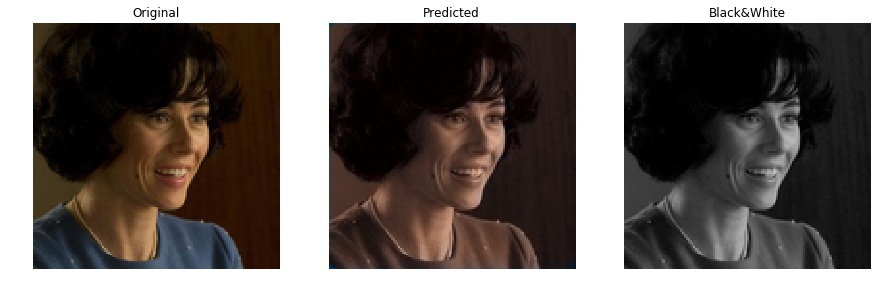

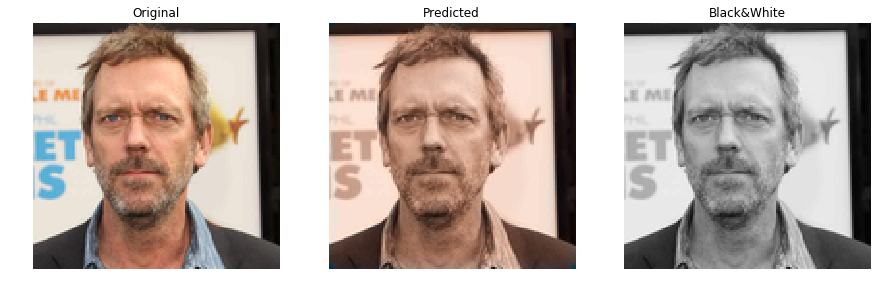

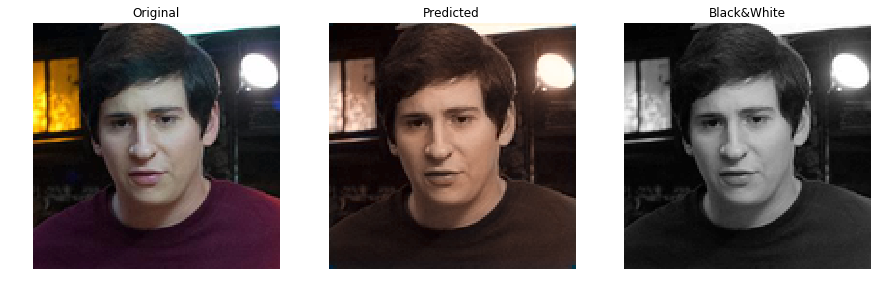

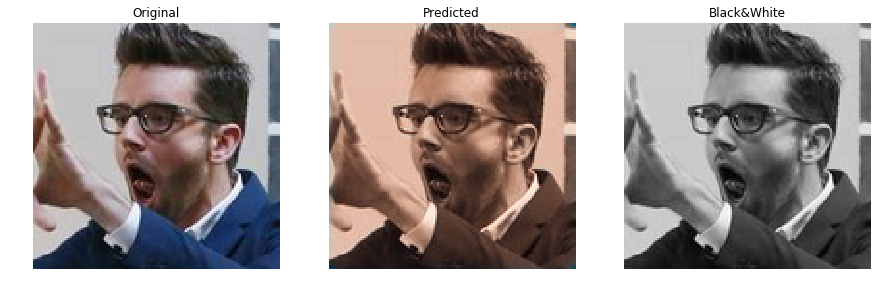

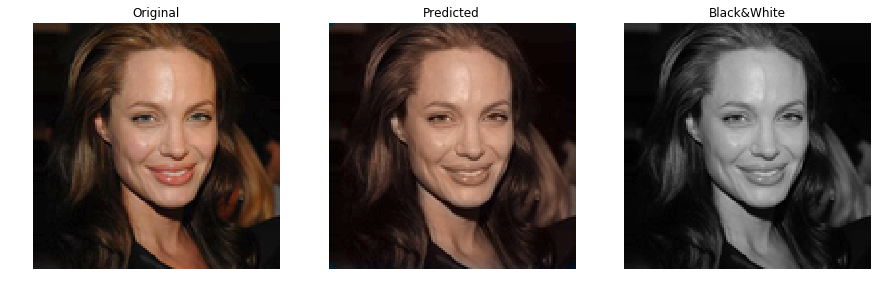

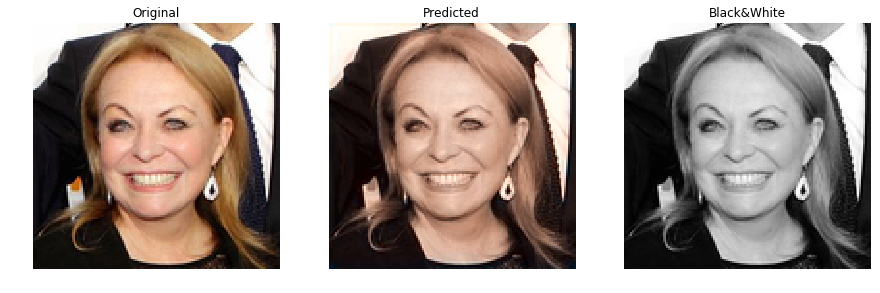

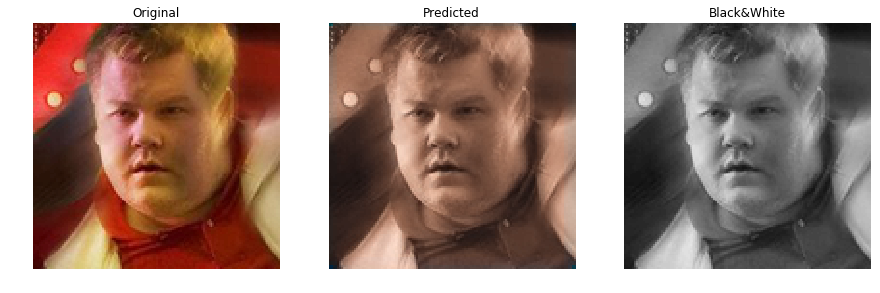

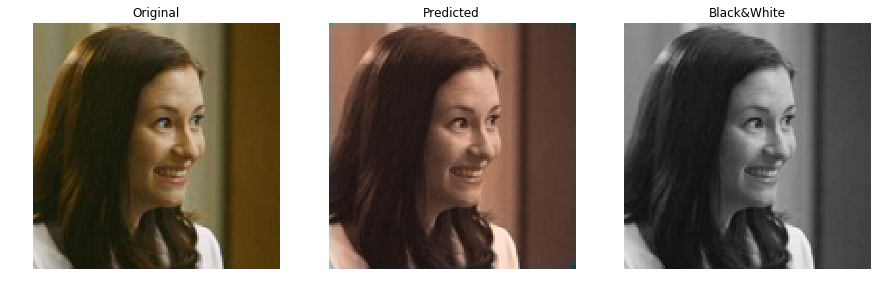

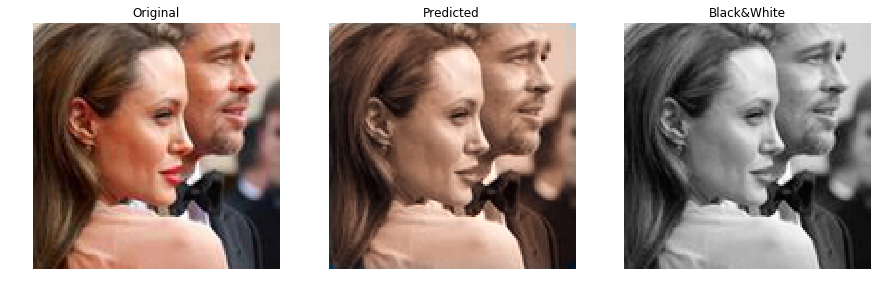

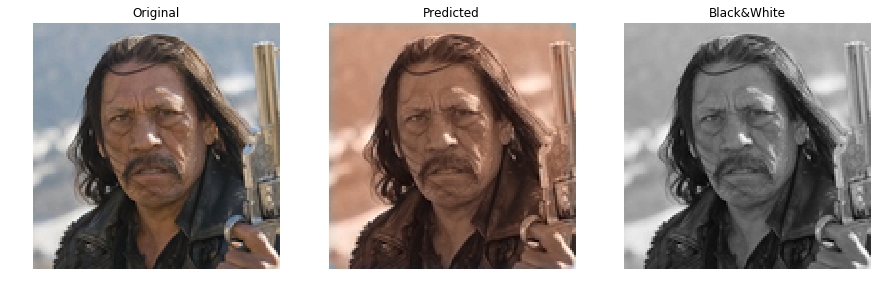

In [60]:
model = load_model('weights.hdf5')
plot_results(model, valid[0:10])

# DenseNet
To solve the vanishing gradient problem we implemented a really basic __[DenseNet](https://arxiv.org/pdf/1608.06993.pdf)__. By this method we could train deeper networks better. But we faced another problem, deeper network requiers more VRAM. We got 4 GB and 1 GB in our computers. <br>
DenseNet was implemented in Keras by others before so I used __[this implementation](https://github.com/flyyufelix/DenseNet-Keras/blob/master/densenet121.py)__ as reference.

In [14]:
from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D, concatenate, BatchNormalization
from keras.layers.core import Dropout

In [ ]:
# a primitive dense block implementation
# more parameters will be added in the future
# x - input layer
# k - growth rate
# return - output layer
def dense_layer(x, k):
    prev = x
    x = BatchNormalization(axis = 3, momentum = 0.9)(x) # prevents overfitting
    x = Conv2D(k, (3, 3), activation='relu', padding='same', strides = 1)(x) # 3x3 convolutional filter
    x = concatenate([prev, x], axis = 3) # atteching the input to the output
    return x

In [31]:
input = Input(shape=(128, 128, 1))

x = dense_layer(input, 1)
x = dense_layer(x, 8)
x = MaxPooling2D((2,2))(x)
x = dense_layer(x, 8)
x = MaxPooling2D((2,2))(x)
x = dense_layer(x, 8)
x = MaxPooling2D((2,2))(x)
x = dense_layer(x, 8)
x = Conv2D(8, (1, 1), activation='relu', padding='same')(x)
x = dense_layer(x, 8)
x = UpSampling2D((2, 2))(x)
x = dense_layer(x, 8)
x = UpSampling2D((2, 2))(x)
x = dense_layer(x, 8)
x = UpSampling2D((2, 2))(x)
x = dense_layer(x, 8)
x = Conv2D(2, (3, 3), activation='linear', padding='same')(x)

model2 = Model(input, x)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model2.compile(optimizer=sgd, loss='mse')
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 128, 128, 1)  4           input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 128, 128, 1)  10          batch_normalization_37[0][0]     
__________________________________________________________________________________________________
concatenate_55 (Concatenate)    (None, 128, 128, 2)  0           input_8[0][0]                    
                                                                 conv2d_67[0][0]                  
__________

In [46]:
checkpointer=ModelCheckpoint(filepath='weights3.hdf5', save_best_only=True, verbose=1)

# model2 = load_model('weights3.hdf5')

# a long training
model2.fit(train[:,:,:,0:1], train[:,:,:,1:3], epochs = 1000, batch_size = 128, verbose=2,
          validation_data=(valid[:,:,:,0:1], valid[:,:,:,1:3]),
          callbacks=[checkpointer])

Train on 7000 samples, validate on 2000 samples
Epoch 1/1000
 - 23s - loss: 0.0022 - val_loss: 0.0021

Epoch 00001: val_loss improved from inf to 0.00212, saving model to weights3.hdf5
Epoch 2/1000
 - 21s - loss: 0.0021 - val_loss: 0.0021

Epoch 00002: val_loss did not improve from 0.00212
Epoch 3/1000
 - 21s - loss: 0.0021 - val_loss: 0.0021

Epoch 00003: val_loss did not improve from 0.00212
Epoch 4/1000
 - 21s - loss: 0.0021 - val_loss: 0.0021

Epoch 00004: val_loss did not improve from 0.00212
Epoch 5/1000
 - 21s - loss: 0.0021 - val_loss: 0.0022

Epoch 00005: val_loss did not improve from 0.00212
Epoch 6/1000
 - 21s - loss: 0.0021 - val_loss: 0.0022

Epoch 00006: val_loss did not improve from 0.00212
Epoch 7/1000
 - 21s - loss: 0.0022 - val_loss: 0.0023

Epoch 00007: val_loss did not improve from 0.00212
Epoch 8/1000
 - 21s - loss: 0.0021 - val_loss: 0.0021

Epoch 00008: val_loss improved from 0.00212 to 0.00211, saving model to weights3.hdf5
Epoch 9/1000
 - 21s - loss: 0.0021 - v


Epoch 00072: val_loss did not improve from 0.00201
Epoch 73/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00073: val_loss did not improve from 0.00201
Epoch 74/1000
 - 21s - loss: 0.0020 - val_loss: 0.0021

Epoch 00074: val_loss did not improve from 0.00201
Epoch 75/1000
 - 21s - loss: 0.0020 - val_loss: 0.0021

Epoch 00075: val_loss did not improve from 0.00201
Epoch 76/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00076: val_loss did not improve from 0.00201
Epoch 77/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00077: val_loss did not improve from 0.00201
Epoch 78/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00078: val_loss did not improve from 0.00201
Epoch 79/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00079: val_loss did not improve from 0.00201
Epoch 80/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00080: val_loss did not improve from 0.00201
Epoch 81/1000
 - 21s - loss: 0.0020 - val_loss: 0.0020

Epoch 00081: val_loss did not improv

 - 22s - loss: 0.0019 - val_loss: 0.0020

Epoch 00146: val_loss improved from 0.00197 to 0.00196, saving model to weights3.hdf5
Epoch 147/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00147: val_loss did not improve from 0.00196
Epoch 148/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00148: val_loss did not improve from 0.00196
Epoch 149/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00149: val_loss did not improve from 0.00196
Epoch 150/1000
 - 22s - loss: 0.0020 - val_loss: 0.0021

Epoch 00150: val_loss did not improve from 0.00196
Epoch 151/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00151: val_loss did not improve from 0.00196
Epoch 152/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00152: val_loss did not improve from 0.00196
Epoch 153/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00153: val_loss improved from 0.00196 to 0.00196, saving model to weights3.hdf5
Epoch 154/1000
 - 22s - loss: 0.0020 - val_loss: 0.0020

Epoch 00154: val_loss di

 - 22s - loss: 0.0019 - val_loss: 0.0020

Epoch 00220: val_loss did not improve from 0.00193
Epoch 221/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00221: val_loss did not improve from 0.00193
Epoch 222/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00222: val_loss did not improve from 0.00193
Epoch 223/1000
 - 22s - loss: 0.0019 - val_loss: 0.0020

Epoch 00223: val_loss did not improve from 0.00193
Epoch 224/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00224: val_loss did not improve from 0.00193
Epoch 225/1000
 - 22s - loss: 0.0019 - val_loss: 0.0020

Epoch 00225: val_loss did not improve from 0.00193
Epoch 226/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00226: val_loss did not improve from 0.00193
Epoch 227/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00227: val_loss did not improve from 0.00193
Epoch 228/1000
 - 22s - loss: 0.0019 - val_loss: 0.0020

Epoch 00228: val_loss did not improve from 0.00193
Epoch 229/1000
 - 22s - loss: 0.0019 - val_


Epoch 00294: val_loss did not improve from 0.00192
Epoch 295/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00295: val_loss improved from 0.00192 to 0.00191, saving model to weights3.hdf5
Epoch 296/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00296: val_loss did not improve from 0.00191
Epoch 297/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00297: val_loss improved from 0.00191 to 0.00191, saving model to weights3.hdf5
Epoch 298/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00298: val_loss did not improve from 0.00191
Epoch 299/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00299: val_loss did not improve from 0.00191
Epoch 300/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00300: val_loss did not improve from 0.00191
Epoch 301/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00301: val_loss did not improve from 0.00191
Epoch 302/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00302: val_loss did not improve from 0.00191
Epoch 303/1000

 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00368: val_loss did not improve from 0.00190
Epoch 369/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00369: val_loss did not improve from 0.00190
Epoch 370/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00370: val_loss did not improve from 0.00190
Epoch 371/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00371: val_loss did not improve from 0.00190
Epoch 372/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00372: val_loss did not improve from 0.00190
Epoch 373/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00373: val_loss did not improve from 0.00190
Epoch 374/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00374: val_loss did not improve from 0.00190
Epoch 375/1000
 - 21s - loss: 0.0019 - val_loss: 0.0020

Epoch 00375: val_loss did not improve from 0.00190
Epoch 376/1000
 - 21s - loss: 0.0019 - val_loss: 0.0020

Epoch 00376: val_loss did not improve from 0.00190
Epoch 377/1000
 - 21s - loss: 0.0019 - val_

 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00443: val_loss did not improve from 0.00189
Epoch 444/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00444: val_loss did not improve from 0.00189
Epoch 445/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00445: val_loss improved from 0.00189 to 0.00189, saving model to weights3.hdf5
Epoch 446/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00446: val_loss did not improve from 0.00189
Epoch 447/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00447: val_loss did not improve from 0.00189
Epoch 448/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00448: val_loss did not improve from 0.00189
Epoch 449/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00449: val_loss did not improve from 0.00189
Epoch 450/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00450: val_loss did not improve from 0.00189
Epoch 451/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00451: val_loss did not improve from 0.00189
Epoch 45


Epoch 00517: val_loss did not improve from 0.00189
Epoch 518/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00518: val_loss did not improve from 0.00189
Epoch 519/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00519: val_loss did not improve from 0.00189
Epoch 520/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00520: val_loss did not improve from 0.00189
Epoch 521/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00521: val_loss did not improve from 0.00189
Epoch 522/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00522: val_loss did not improve from 0.00189
Epoch 523/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00523: val_loss did not improve from 0.00189
Epoch 524/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00524: val_loss did not improve from 0.00189
Epoch 525/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00525: val_loss did not improve from 0.00189
Epoch 526/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00526: val_loss did n


Epoch 00592: val_loss did not improve from 0.00188
Epoch 593/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00593: val_loss did not improve from 0.00188
Epoch 594/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00594: val_loss did not improve from 0.00188
Epoch 595/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00595: val_loss did not improve from 0.00188
Epoch 596/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00596: val_loss did not improve from 0.00188
Epoch 597/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00597: val_loss did not improve from 0.00188
Epoch 598/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00598: val_loss did not improve from 0.00188
Epoch 599/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00599: val_loss did not improve from 0.00188
Epoch 600/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00600: val_loss did not improve from 0.00188
Epoch 601/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00601: val_loss did n

 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00666: val_loss did not improve from 0.00187
Epoch 667/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00667: val_loss did not improve from 0.00187
Epoch 668/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00668: val_loss did not improve from 0.00187
Epoch 669/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00669: val_loss did not improve from 0.00187
Epoch 670/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00670: val_loss did not improve from 0.00187
Epoch 671/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00671: val_loss improved from 0.00187 to 0.00187, saving model to weights3.hdf5
Epoch 672/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00672: val_loss did not improve from 0.00187
Epoch 673/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00673: val_loss did not improve from 0.00187
Epoch 674/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00674: val_loss did not improve from 0.00187
Epoch 67

 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00741: val_loss did not improve from 0.00186
Epoch 742/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00742: val_loss did not improve from 0.00186
Epoch 743/1000
 - 21s - loss: 0.0019 - val_loss: 0.0020

Epoch 00743: val_loss did not improve from 0.00186
Epoch 744/1000
 - 21s - loss: 0.0019 - val_loss: 0.0019

Epoch 00744: val_loss improved from 0.00186 to 0.00186, saving model to weights3.hdf5
Epoch 745/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00745: val_loss did not improve from 0.00186
Epoch 746/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00746: val_loss did not improve from 0.00186
Epoch 747/1000
 - 22s - loss: 0.0019 - val_loss: 0.0019

Epoch 00747: val_loss did not improve from 0.00186
Epoch 748/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00748: val_loss did not improve from 0.00186
Epoch 749/1000
 - 23s - loss: 0.0019 - val_loss: 0.0019

Epoch 00749: val_loss did not improve from 0.00186
Epoch 75

 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00816: val_loss did not improve from 0.00186
Epoch 817/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00817: val_loss did not improve from 0.00186
Epoch 818/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00818: val_loss did not improve from 0.00186
Epoch 819/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00819: val_loss did not improve from 0.00186
Epoch 820/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00820: val_loss did not improve from 0.00186
Epoch 821/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00821: val_loss did not improve from 0.00186
Epoch 822/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00822: val_loss improved from 0.00186 to 0.00186, saving model to weights3.hdf5
Epoch 823/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00823: val_loss did not improve from 0.00186
Epoch 824/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00824: val_loss did not improve from 0.00186
Epoch 82

 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00891: val_loss did not improve from 0.00185
Epoch 892/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00892: val_loss did not improve from 0.00185
Epoch 893/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00893: val_loss did not improve from 0.00185
Epoch 894/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00894: val_loss did not improve from 0.00185
Epoch 895/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00895: val_loss did not improve from 0.00185
Epoch 896/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00896: val_loss did not improve from 0.00185
Epoch 897/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00897: val_loss did not improve from 0.00185
Epoch 898/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00898: val_loss did not improve from 0.00185
Epoch 899/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00899: val_loss did not improve from 0.00185
Epoch 900/1000
 - 22s - loss: 0.0018 - val_

 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00966: val_loss did not improve from 0.00184
Epoch 967/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00967: val_loss did not improve from 0.00184
Epoch 968/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00968: val_loss did not improve from 0.00184
Epoch 969/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00969: val_loss did not improve from 0.00184
Epoch 970/1000
 - 23s - loss: 0.0018 - val_loss: 0.0019

Epoch 00970: val_loss did not improve from 0.00184
Epoch 971/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00971: val_loss did not improve from 0.00184
Epoch 972/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00972: val_loss did not improve from 0.00184
Epoch 973/1000
 - 22s - loss: 0.0018 - val_loss: 0.0019

Epoch 00973: val_loss did not improve from 0.00184
Epoch 974/1000
 - 22s - loss: 0.0018 - val_loss: 0.0018

Epoch 00974: val_loss did not improve from 0.00184
Epoch 975/1000
 - 22s - loss: 0.0018 - val_

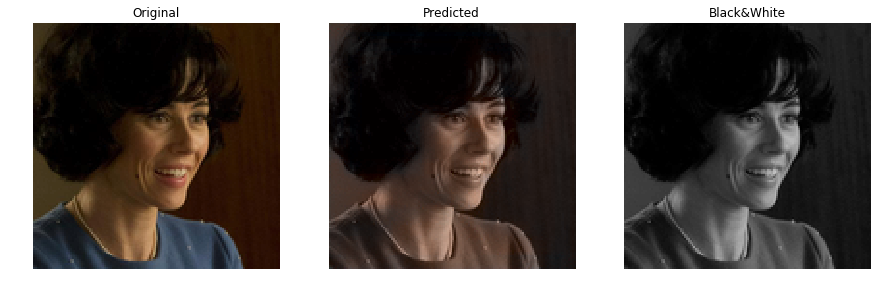

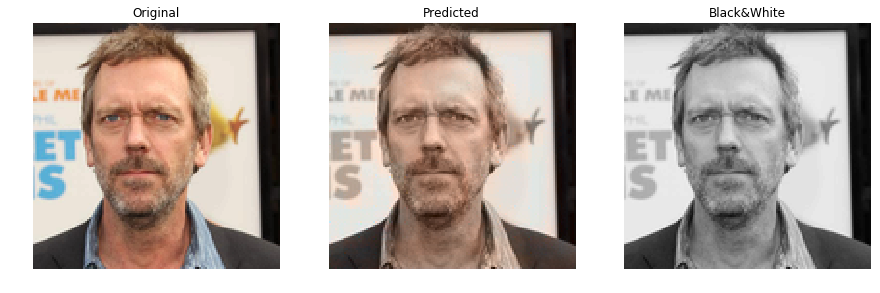

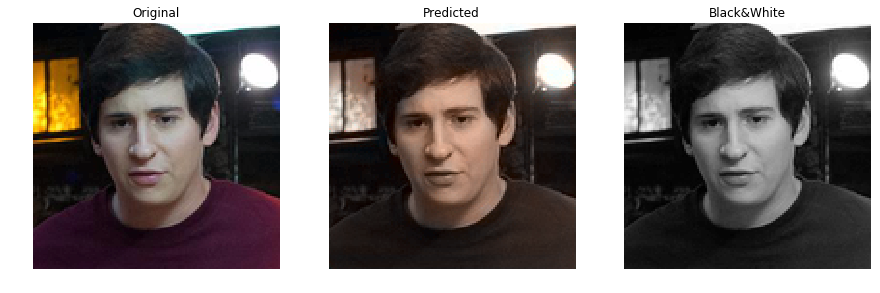

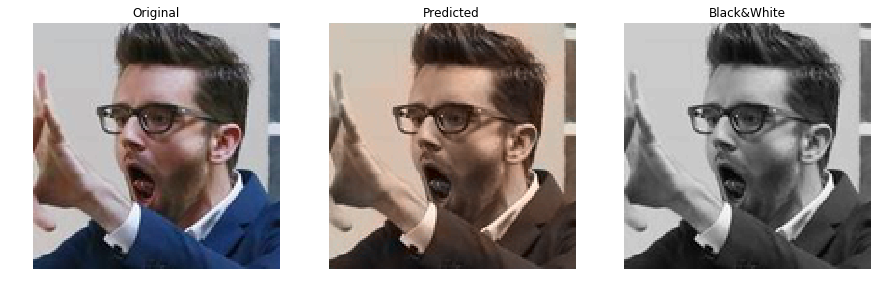

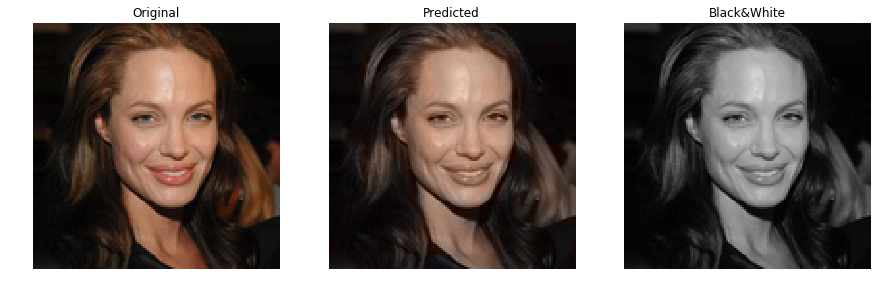

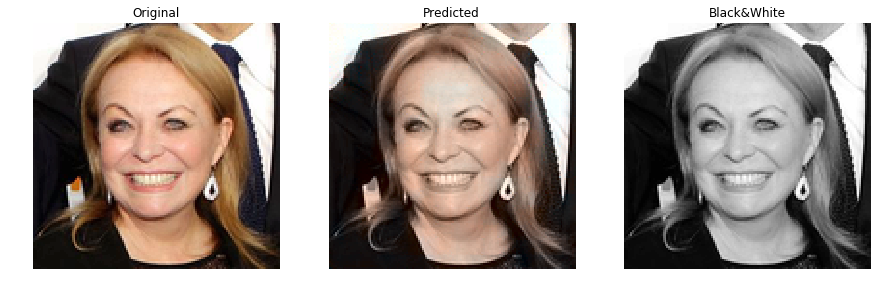

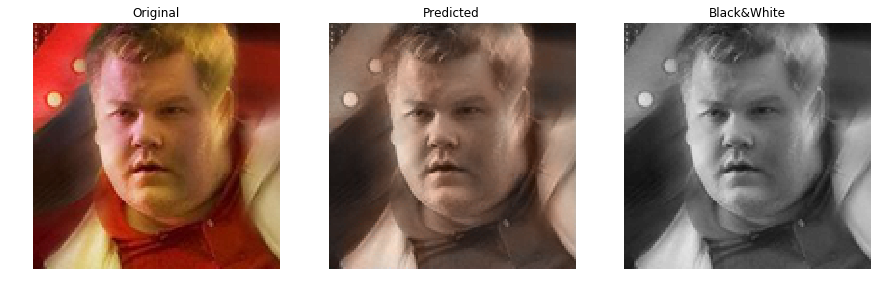

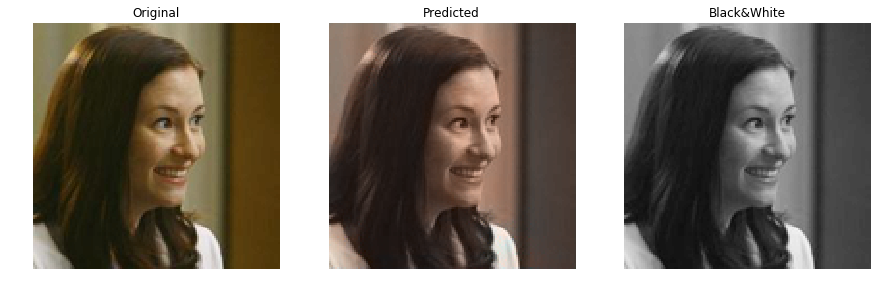

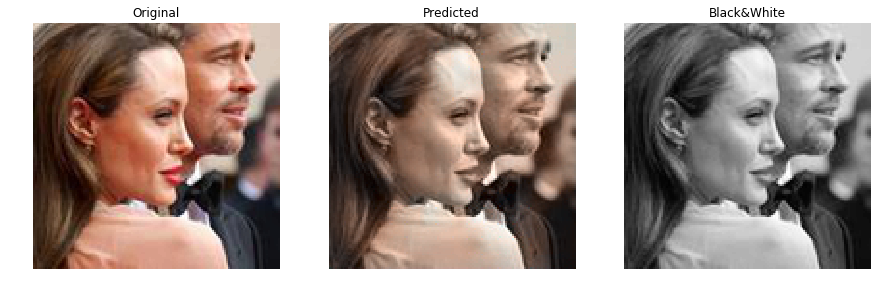

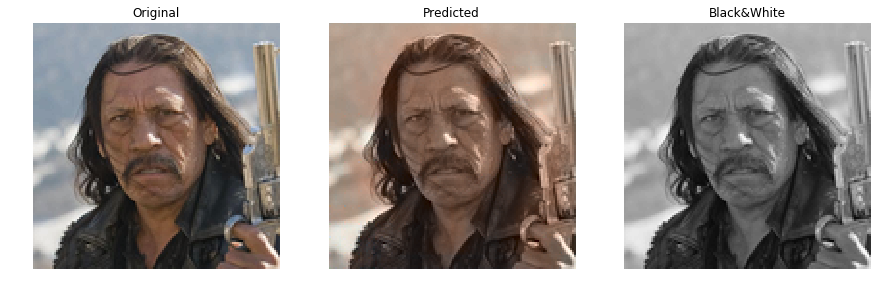

In [8]:
model2 = load_model('weights3.hdf5')
plot_results(model2, valid[0:10])

### Conclusion
The narrow CNN, which was traind only a few epochs and the bit deeper DenseNet, which was trained more than 1000 epochs resulted almost the same. Both can't color properly yet. So we will try other configurations too, e.g.: with a fusion layer like in __[this](https://github.com/emilwallner/Coloring-greyscale-images-in-Keras)__ and __[this](https://github.com/baldassarreFe/deep-koalarization)__ studies.